In [1]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import glob
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
import datetime
import matplotlib.pyplot as plt

/Users/alyssa/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#grab wrangled data files
transcripts = glob.glob('../data/Trump/*.txt')


['../data/Trump/October272019.txt', '../data/Trump/May302020.txt', '../data/Trump/January082020.txt', '../data/Trump/April162020.txt', '../data/Trump/August052019.txt', '../data/Trump/July152020.txt', '../data/Trump/June262020.txt', '../data/Trump/July232019.txt', '../data/Trump/May072020.txt', '../data/Trump/May212020.txt', '../data/Trump/August052020.txt', '../data/Trump/July052019.txt', '../data/Trump/March032020.txt', '../data/Trump/March132020.txt', '../data/Trump/July042020.txt', '../data/Trump/August142019.txt', '../data/Trump/April282020.txt', '../data/Trump/July312019.txt', '../data/Trump/May152020.txt', '../data/Trump/May052020.txt', '../data/Trump/June132020.txt', '../data/Trump/March112020.txt', '../data/Trump/January242020.txt', '../data/Trump/July162020.txt', '../data/Trump/July282020.txt', '../data/Trump/May222020.txt', '../data/Trump/April192016.txt', '../data/Trump/February102020.txt', '../data/Trump/July072020.txt', '../data/Trump/August062020.txt', '../data/Trump/Aug

In [3]:
#separate into training/testing by fraction
trainFrac = int(len(transcripts)*0.80)

random.shuffle(transcripts)

training = transcripts[:trainFrac]
testing = transcripts[trainFrac:]

In [4]:
#get bag of words for each speech in training and
#testing datasets
training_speeches = []
for i in range(len(training)):
    speech = open(training[i],'r')
    words = []
    for line in speech:
        words += word_tokenize(line)
    seperator = ' '
    training_speeches.append(seperator.join(words))

testing_speeches = []
for i in range(len(testing)):
    speech = open(testing[i],'r')
    words = []
    for line in speech:
        words += word_tokenize(line)
    sperator = ' '
    testing_speeches.append(seperator.join(words))
    

In [5]:
#format bag of words
cv = CountVectorizer(analyzer = 'word', max_features = 50, lowercase=True, preprocessor=None, tokenizer=None, stop_words = 'english')  
training_vectors = cv.fit_transform(training_speeches)
testing_vectors = cv.fit_transform(testing_speeches)

training_classification = []
prediction = []

#cycle through k-means for 3-10 clusters
for k in range(2,12):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans_indices = kmeans.fit_predict(training_vectors)
    training_classification.append(kmeans_indices)
    predicted_indices = kmeans.predict(testing_vectors)
    prediction.append(predicted_indices)
 
    k += 1

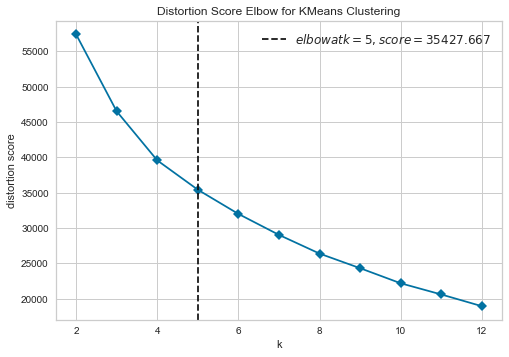

In [6]:
visualizer = KElbowVisualizer(kmeans,k=(2,13), timings=False)
visualizer.fit(training_vectors)
visualizer.show()

In [7]:
elbow = 5


In [8]:
kmeans = KMeans(n_clusters = elbow, init = 'k-means++', random_state = 0)
kmeans_indices = kmeans.fit_predict(training_vectors)
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(elbow):
    print("Cluster %d: " % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0: 
 god
 today
 families
 years
 world
 think
 nation
 things
 new
 type
Cluster 1: 
 god
 families
 years
 thing
 job
 lot
 pence
 things
 schools
 new
Cluster 2: 
 god
 pence
 years
 thing
 lot
 families
 things
 going
 job
 new
Cluster 3: 
 god
 united
 place
 pence
 families
 going
 thing
 years
 country
 things
Cluster 4: 
 god
 thing
 place
 lot
 pence
 families
 things
 think
 students
 children


# DOW JONES

In [9]:
dowjones = pd.read_csv('../dowjones/DJI.csv')
dowjones.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-11,17593.589844,17593.589844,17352.630859,17402.839844,17402.839844,103010000
1,2015-08-12,17382.929688,17423.900391,17125.810547,17402.509766,17402.509766,120400000
2,2015-08-13,17401.640625,17481.779297,17341.339844,17408.250000,17408.250000,88550000
3,2015-08-14,17410.119141,17492.900391,17394.060547,17477.400391,17477.400391,82120000
4,2015-08-17,17472.660156,17551.400391,17341.720703,17545.179688,17545.179688,73380000


In [10]:
dowjones.drop(columns=['Open','High','Low','Adj Close'],inplace=True)
dowjones['Date'] = pd.to_datetime(dowjones['Date'])

In [13]:
classified_clusters = kmeans_indices 
#predicted_clusters = kmeans.predict(testing_vectors)
speech_dates = training
#speech_dates = transcripts
dates = []
for i in range(len(speech_dates)):
    date_time_str = speech_dates[i][14:-4] #add spaces
    date_time_obj = datetime.datetime.strptime(date_time_str, '%B%d%Y')
    dates.append(date_time_obj)

In [14]:
speeches = {'speech_date':dates, 'Cluster':classified_clusters, 'Close':np.zeros(len(dates))}
speeches_df = pd.DataFrame(data=speeches)

In [15]:
close = []
#match the dowjones 'close' to the date of speeches 
for i in range(len(speeches_df)):
    for j in range(len(dowjones)):
        if (dowjones['Date'].iloc[j] == speeches_df['speech_date'].iloc[i]):
            close.append([speeches_df['speech_date'].iloc[i],dowjones['Close'].iloc[j],
                          speeches_df['Cluster'].iloc[i]])

In [16]:
new_df = pd.DataFrame(data=close,columns=['Date','Close','Cluster'])
new_df.head()

,Date,Close,Cluster
0,2020-06-23,26156.099609,2
1,2020-04-28,24101.550781,4
2,2019-08-05,25717.740234,0
3,2020-01-08,28745.089844,0
4,2020-07-16,26734.710938,1


In [17]:
X = new_df['Cluster'].values.reshape(-1,1)
y = new_df['Close'].values


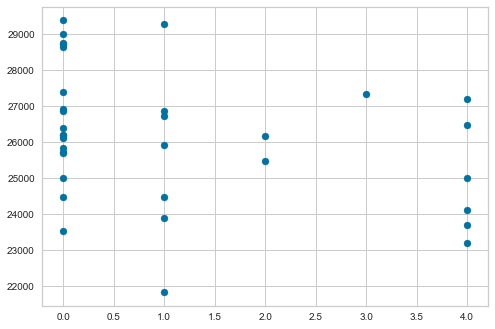

In [18]:
plt.scatter(new_df['Cluster'],new_df['Close'])
#new_df.boxplot(column='Close',by='Cluster')

In [ ]:
#Q1 = new_df[new_df['Cluster']==0].quantile(0.25)
#new_df = new_df[new_df['Close'] > Q1['Close']]

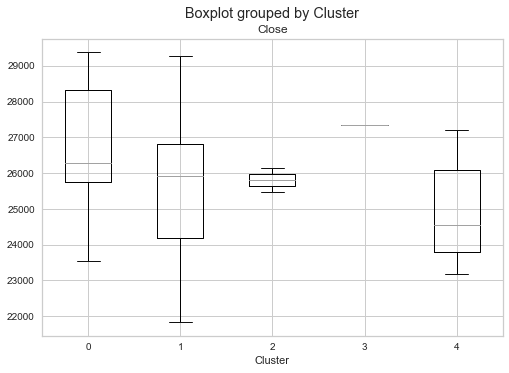

In [19]:
new_df.boxplot(column='Close',by='Cluster')